# ADS 599 Team 7 Final Project

## Image Classification For Pneumonia Detection using Chest X-Ray Images

#### University of San Diego - Applied Data Science
#### Chow, Eva
#### Duan, Dingyi 
#### Tan, Abby

#### Github Link: https://github.com/dingyiduan7/ADS599_Capstone_Image_Recognition

### Load the necessary packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import joblib

from pathlib import Path
from random import randint

from scipy import ndimage

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from tensorflow import keras  
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from keras.models import Sequential
from tensorflow.keras.models import save_model

from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, MaxPooling2D, Activation, Input
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Stage 1: Data Loading and Exploratory Data Analysis (EDA)

The following is a check of all our datasets/folders.

In [3]:
# print(os.listdir("D:/USD-ADS_graduate/ADS-599/chest_xray"))
# print(os.listdir("D:/USD-ADS_graduate/ADS-599/chest_xray/train"))
# print(os.listdir("D:/USD-ADS_graduate/ADS-599/chest_xray/val"))
# print(os.listdir("D:/USD-ADS_graduate/ADS-599/chest_xray/test"))

Our dataset has been sorted into three separate folders: train, validation, and test sets.
Each folder contains two subfolders: "NORMAL" and "PNEUMONIA" classified images.

In [4]:
# Set the path for all three datasets.
# data_dir = Path("D:/USD-ADS_graduate/ADS-599/chest_xray/")
# train_dir = data_dir/"train"
# val_dir = data_dir/"val"
# test_dir = data_dir/"test"

In [5]:
# Set the path for all three datasets.
# data_dir = Path("C:/Users/abby0/OneDrive/Desktop/MSADS/ADS-599 Capstone/Project/chest_xray/")
# train_dir = data_dir/"train"
# val_dir = data_dir/"val"
# test_dir = data_dir/"test"

In [6]:
# Set the path for all three datasets.
data_dir = Path("/Users/evachow/Documents/Documents - Eva’s Mac mini/USD/ADS599/Capstone/chest_xray")
train_dir = data_dir/"train"
val_dir = data_dir/"val"
test_dir = data_dir/"test"

In [7]:
# Define a function to load the data into dataframes.
# Assign labels corresponding to the folder names.

def load_data(data_path):
    # Below defines the directories for our "NORMAL" and "PNEUMONIA" images.
    normal_dir = data_path/"NORMAL"
    pneum_dir = data_path/"PNEUMONIA"
    
    # The images are in .jpeg format, so we will use glob() to retrieve
    # file/pathnames that match the jpeg format.    normal_img = normal_dir.glob('*.jpeg')
    normal_img = normal_dir.glob('*.jpeg')
    pneum_img = pneum_dir.glob('*.jpeg')
    
    # Generate lists of our image data and image label.
    img_data = []
    img_label = []
    
    for img in normal_img:
        img_data.append(img)
        img_label.append('NORMAL')
        
    for img in pneum_img:
        img_data.append(img)
        img_label.append('PNEUMONIA')
    df = pd.DataFrame(img_data,columns=['images'])
    df['label'] = img_label
    df = df.reset_index(drop=True)
    
    return df

In [8]:
# Define the training dataframe and sample randomly to check labeling.
df_train = load_data(train_dir)
print(df_train.sample(10))

                                                 images      label
1977  /Users/evachow/Documents/Documents - Eva’s Mac...  PNEUMONIA
2625  /Users/evachow/Documents/Documents - Eva’s Mac...  PNEUMONIA
2033  /Users/evachow/Documents/Documents - Eva’s Mac...  PNEUMONIA
305   /Users/evachow/Documents/Documents - Eva’s Mac...     NORMAL
1479  /Users/evachow/Documents/Documents - Eva’s Mac...  PNEUMONIA
4674  /Users/evachow/Documents/Documents - Eva’s Mac...  PNEUMONIA
4021  /Users/evachow/Documents/Documents - Eva’s Mac...  PNEUMONIA
2746  /Users/evachow/Documents/Documents - Eva’s Mac...  PNEUMONIA
3300  /Users/evachow/Documents/Documents - Eva’s Mac...  PNEUMONIA
1586  /Users/evachow/Documents/Documents - Eva’s Mac...  PNEUMONIA


In [9]:
# Now define the validation and test dataframes.
# Check the shape of our dataframes to ensure no image loss and correct shape.
df_val = load_data(val_dir)
df_test = load_data(test_dir)
print('The training data has a shape of:',df_train.shape)
print('The validate data has a shape of:',df_val.shape)
print('The test data has a shape of:',df_test.shape)

The training data has a shape of: (5216, 2)
The validate data has a shape of: (16, 2)
The test data has a shape of: (624, 2)


Let's check to see whether the training set is balanced.

<AxesSubplot: title={'center': 'Training Data Label Distribution'}>

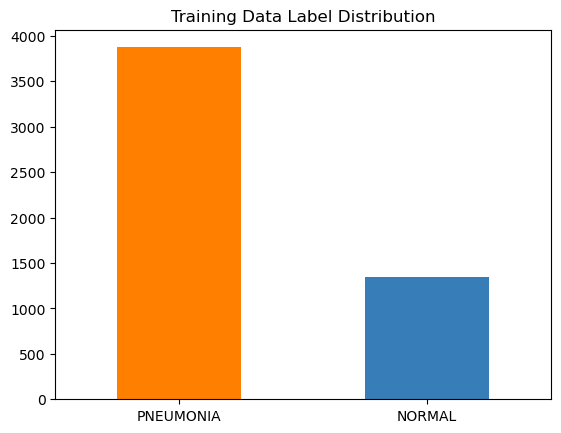

In [10]:
# Check the distribution of "NORMAL" vs "PNEUMONIA" images within the
# training dataset.
df_train['label'].value_counts().plot(kind='bar',rot=0,title="Training Data Label Distribution",color=['#ff7f00','#377eb8'])

There is clear imbalance within our training dataset, with "PNEUMONIA" labeled images greatly outnumbering the "NORMAL" images. Oversampling may be performed later pending model performance.

In [11]:
# attribibutes for a single raw image


Look at a random sample of images to examine and note differences between the images, if any.

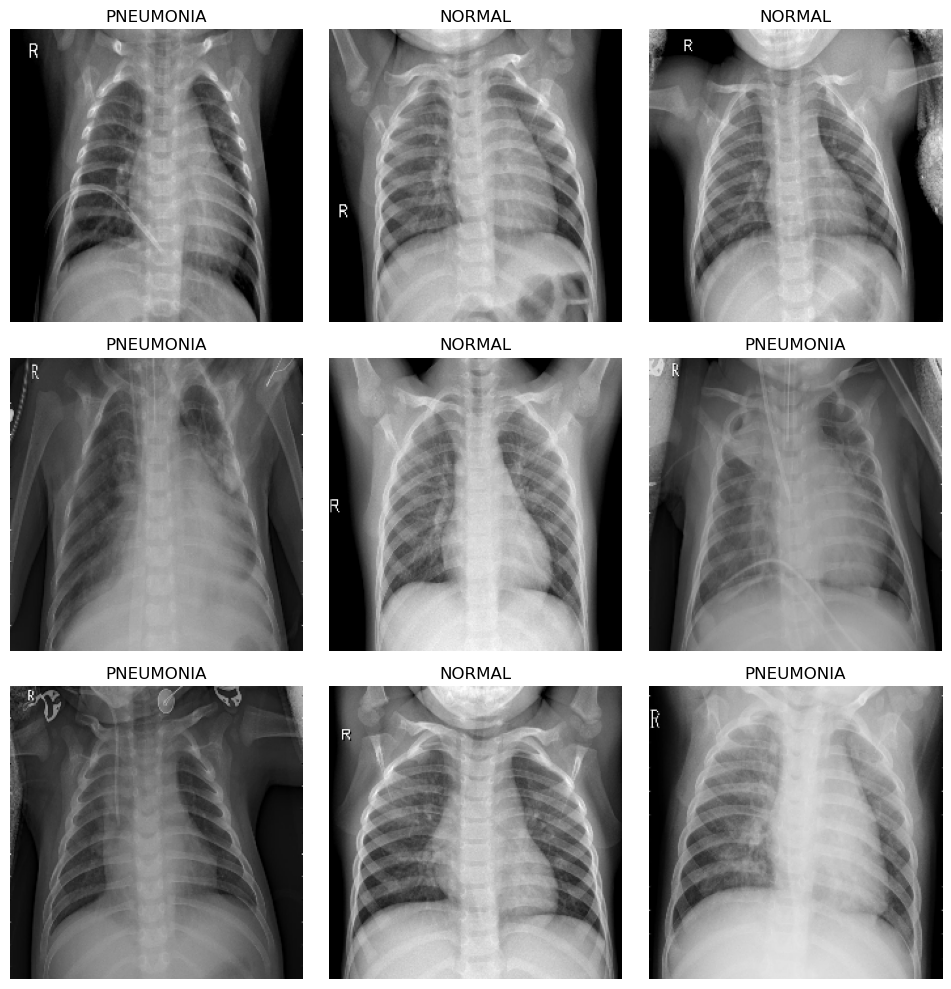

In [12]:
# Generate a grid of randomly sampled images for raw image comparisons.
plt.figure(figsize=(10,10))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    j = randint(0, len(df_train))
    img_path = str(df_train['images'][j])
    img = cv2.imread(img_path)
    # Note that cv2.resize is used to normalize the image sizes for visual comparison.
    img = cv2.resize(img,(224,224))
    plt.title(df_train['label'][j])
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()

There are a few observations after looking at our raw images:
- There is a variety of quality differences between the images.
- Some of these image differences are negligible and hard to discern with bare eyes.
- Some images, even those labeled as "NORMAL", may appear cloudier.
- Unless trained professionally, discerning "NORMAL" vs "PNEUMONIA" classification visually is difficult.

Look at flattened arrays of randomly sampled images to examine and note any differences.

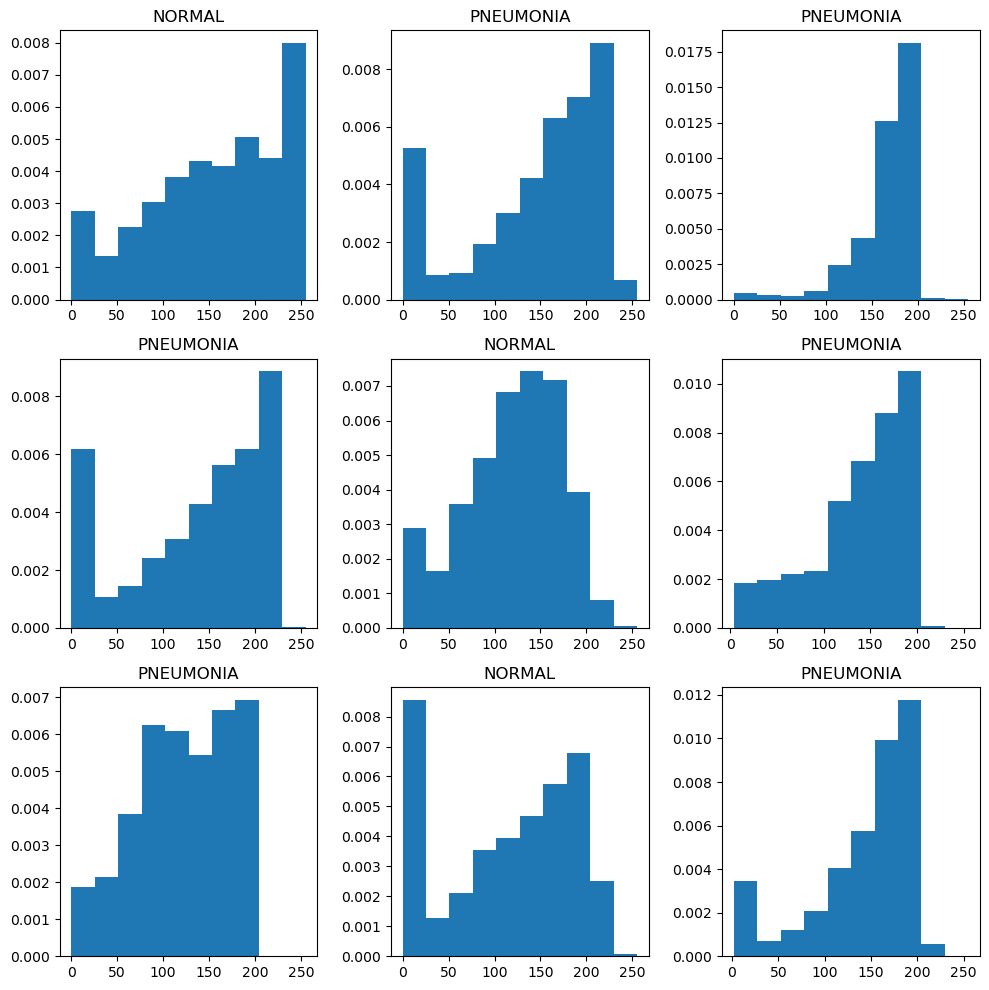

In [13]:
# Using histograms, compare the intensity values between randomly sampled images.
plt.figure(figsize=(10,10))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    j = randint(0, len(df_train))
    img_path = str(df_train['images'][j])
    img = cv2.imread(img_path)
    # Note that cv2.resize is used to normalize the image sizes for visual comparison.
    # While this may alter the distribution, this normalization will still display the general
    # trend of the intensity value distribution for each image. 
    img = cv2.resize(img,(224,224))
    plt.title(df_train['label'][j])
    plt.hist(img.flatten(), density=True)
    plt.tight_layout()

From the samples, it appears that images labeled "PNEUMONIA" may display more skew than "NORMAL" classified images.

## Stage 2: Data Cleaning and Preprocessing

### Image Formatting/ Image Augmentation


Reference: https://iq.opengenus.org/basics-of-machine-learning-image-classification-techniques/

Let's take a random sample from our training set and look at how different image formatting and augmentation will take effect on our images.

(-0.5, 1254.5, 882.5, -0.5)

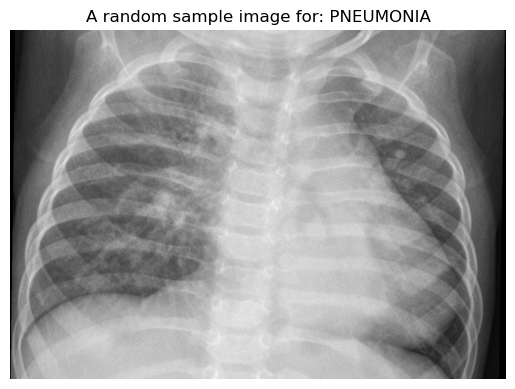

In [14]:
sample_ind = randint(0, len(df_train))
sample_path= str(df_train['images'][sample_ind])
sample_img = cv2.imread(sample_path)
plt.title('A random sample image for: %s'%df_train['label'][sample_ind])
plt.imshow(sample_img)
plt.axis('off')

#### Descriptive Statistics for Sample Image

In [15]:
print('For the sample image: \n')
print('Image Type: ' , type(sample_img)) 
print('Image Shape: {}'.format(sample_img.shape)) 
print('Image Height: {}'.format(sample_img.shape[0])) 
print('Image Width: {}'.format(sample_img.shape[1])) 
print('Image Dimension: {}'.format(sample_img.ndim))
print('Image size: {}'.format(sample_img.size)) 
print('Maximum intensity value: {}'.format(sample_img.max())) 
print('Minimum intensity value: {}'.format(sample_img.min()))

For the sample image: 

Image Type:  <class 'numpy.ndarray'>
Image Shape: (883, 1255, 3)
Image Height: 883
Image Width: 1255
Image Dimension: 3
Image size: 3324495
Maximum intensity value: 248
Minimum intensity value: 0


There are some quick observations regarding our images:
- The images present as an array.
- The images vary in image height and width.
- All images have a 3 dimensional format.
- The maximum and minimum intensity values for all of the images are 255 and 0, respectively.

All image processing steps that follow are manipulations of the images as arrays.

In [16]:
# This function will make it easier to return our original, unaltered image for comparison.
def original(img):
    return img

#### 1. Resizing 
Resize the image to a specified pixel length and width.

In [17]:
# This function will return an image that is 50x50, which is smaller than our original image.
def resizing(img):
    res_img = cv2.resize(img, (50,50)) # Change the width and height here.
    return res_img

#### 2. Gray Scaling Utilizing OpenCV
The image will be converted between a gray scale color space to a BGR color space, depending on the original state of the image. The intensity values of the image are used to facilitate this conversion. As the images are already gray scaled, they will instead be converted into a BGR color space.

In [18]:
# This function will change the color space of an image using the cv2 package.
def gray_scale(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray_img

#### 3. Reflection/Flip
An image can be flipped vertically or horizontally. While some frameworks do not provide a function for vertical flips, this can be achieved by rotating an image 180 degrees and then performing a horizontal flip.

In [19]:
# This function will flip the image vertically by using cv2.flip(img,1),
# which swaps the left and right sides of the image.
# To flip horizontally, use cv2.flip(img,0).
def ref_flip(img):
    flip_img = cv2.flip(img,1)
    return flip_img

#### 4. Gaussian Blurring
Gaussian blur (also known as Gaussian smoothing) is the result of blurring an image by a Gaussian function. It is a widely used effect in graphics software, typically to reduce image noise.

In [20]:
# This functions applies a Gaussian blur over the image.
# The intensity of the blur can be changed by adjusting sigma.
def gau_blur(img):
    blur_img = ndimage.gaussian_filter(img, sigma= 5.11)
    return blur_img

#### 5. Histogram Equalization
Histogram equalization increases global contrast of an image using the image intensity histogram. This method needs no parameter, but can result in unnatural looking images.

In [21]:
# This function increases image contrast by taking the most frequent 
# intensity values and spreading them out.
def hist_eq(img):
    img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
    img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
    hist_img= cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
    return hist_img

#### 6. Rotation
Rotating an image turns the image. Note that this might not preserve the original dimensions of an image. This dimension preservation depends largely on the angle of rotation.

In [22]:
# This function will rotate our image.
def rotation(img):
    rows,cols = img.shape[0],img.shape[1]
    randDeg = random.randint(-180, 180)
    matrix = cv2.getRotationMatrix2D((cols/2, rows/2), randDeg, 0.70)
    rot_img = cv2.warpAffine(img, matrix, (rows, cols), borderMode=cv2.BORDER_CONSTANT)
    return rot_img 

#### 7. Channel Conversion
Some images are in  greyscale (1 channel). This utilizes np.dstack in order to convert them to 3 channel by concatenating along the third dimension of our image.

In [23]:
# This function concatenates our image along the third dimension.
def channel_con(img):
    if img.shape[2]==1:
        img = dstack([img,img,img])
    return img 

#### Color Conversion
Using OpenCV, the image will be shifted into an alternate color space. cv2.COLOR_BGR2RGB will shift the color space from BGR to RGB, which has a different arrangement of sub-pixels.

In [24]:
# This function utilizes cv2 to shift the color space.
def color_con(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

#### Augmentation Comparison

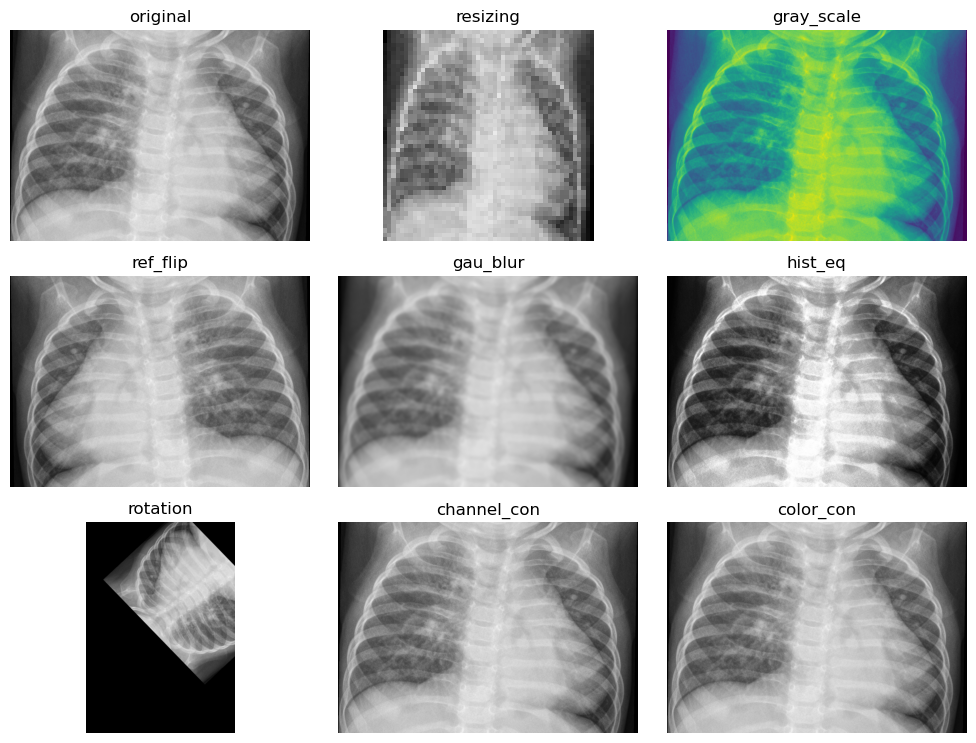

In [25]:
# Define a pipeline that will run a sample image through the various augmentation techniques.
img_aug = [original, resizing, gray_scale, ref_flip, gau_blur, hist_eq, rotation, channel_con, color_con]

# Display a grid of each technique applied to an image.
plt.figure(figsize=(10,10))
for aug in img_aug:
    ax = plt.subplot(4,3,img_aug.index(aug)+1)
    sample_img = cv2.imread(sample_path)
    sample_img = aug(sample_img)
    plt.title(aug.__name__)
    plt.imshow(sample_img)
    plt.axis('off')
    plt.tight_layout()   

Upon observation, we can see that:

- When resizing our image, this will result in an image with altered resolution. 
- In gray-scaling, because our images were already gray-scale, this appears to have converted the image using another color space (BGR).
- In ref_flip, while this successfully flipped our image vertically, we will choose to forgo this augmentation technique due to the medical importance of anatomical positioning (i.e. left versus right sides of the body).
- Gaussian blur has smoothed out the harsh edges within the image. This may prove unhelpful in detecting aspects of the image that may help in classifying "PNEUMONIA" images.
- Histogram equalization has visibly increased the constrast of our images.
- Rotation has disorted image size and quality. We will forgo this augmentation technique as it seems unhelpful.
- Channel conversion does not appear to have caused major impacts to the image. This may be forgone in our augmentation techniques.
- Color conversion also does not appear to have major impacts on the image.

Apply all image augmentation techniques in order to see if there are any benefits to utilizing all techniques examined.

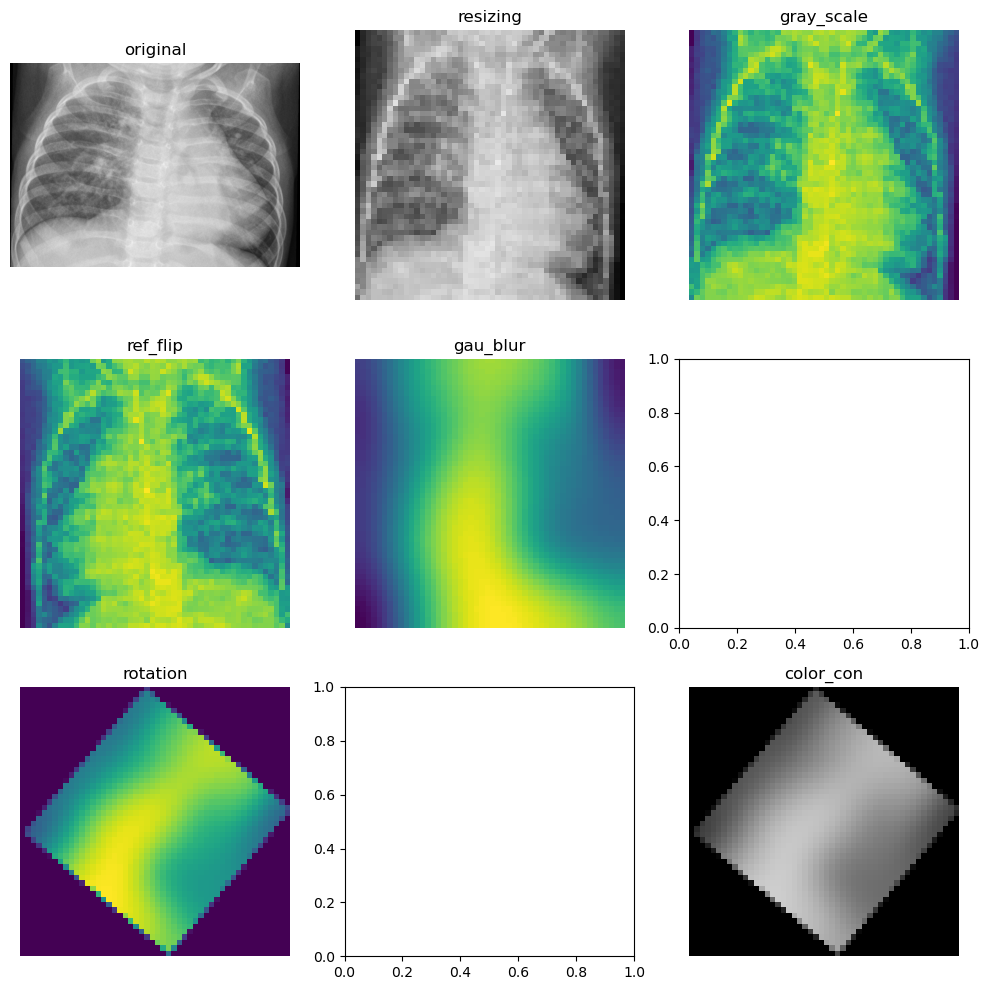

In [26]:
# Define a function where after each augmentation technique application, the next
# technique is then applied to the newly augmented image and so on until all
# techniques within the pipeline have been applied.
img_aug = [original, resizing, gray_scale, ref_flip, gau_blur, hist_eq, rotation, channel_con, color_con]
sample_img = cv2.imread(sample_path)
plt.figure(figsize=(10,10))
for aug in img_aug:
    try:
        ax = plt.subplot(3,3,img_aug.index(aug)+1)
        sample_img = aug(sample_img)
        plt.title(aug.__name__)
        plt.imshow(sample_img)
        plt.axis('off')
        plt.tight_layout()  
    except:
        pass

After looking at all augmentation techniques applied, we can conclude that it is not reasonable to implement all techniques at the risk of:
- Distorting the image in a way that may not help model performance.
- Distorting the image in a way that anatomical accuracy is lost.
- Interference with other augmentation techniques.

Of the techniques experimented with, the ones that will be implemented are:
- Resizing (for our modeling, we'll resize all images to a uniform 224 x 224 size).
- Gray-scaling (as seen previously, this will convert the image, which is already gray-scaled, to a BGR color space)

In [27]:
# This new resizing function (defined as resizing2) will 
# resize an image to 224 x 224 pixels.
def resizing2(img):
    res_img = cv2.resize(img, (224,224))
    return res_img

For the sample image: 

Image Type:  <class 'numpy.ndarray'>
Image Shape: (224, 224)
Image Hight: 224
Image Width: 224
Image Dimension: 2
Image size: 50176
Maximum intensity value: 247
Minimum intensity value: 0


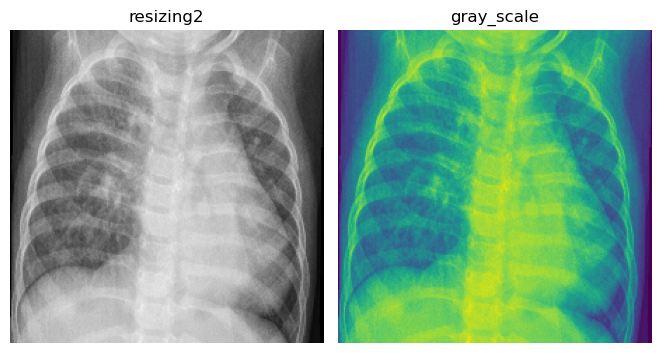

In [28]:
# Define an image processing pipeline that resizes an image using resizing2
# and applies the gray-scale function defined previously.
img_aug = [resizing2, gray_scale]
sample_img = cv2.imread(sample_path)
plt.figure(figsize=(10,10))
for aug in img_aug:
    ax = plt.subplot(1, 3, img_aug.index(aug)+1)
    sample_img = aug(sample_img)
    plt.title(aug.__name__)
    plt.imshow(sample_img)
    plt.axis('off')
    plt.tight_layout()   

# Print descriptive statistics of this pipeline applied to a 
# randomly sampled image.
print('For the sample image: \n')
print('Image Type: ' , type(sample_img)) 
print('Image Shape: {}'.format(sample_img.shape)) 
print('Image Hight: {}'.format(sample_img.shape[0])) 
print('Image Width: {}'.format(sample_img.shape[1])) 
print('Image Dimension: {}'.format(sample_img.ndim))
print('Image size: {}'.format(sample_img.size)) 
print('Maximum intensity value: {}'.format(sample_img.max())) 
print('Minimum intensity value: {}'.format(sample_img.min()))

With the new image processing pipeline applied, some observations about the new image are as follows:
- The number of dimensions of the image has reduced to 2, which is likely a result of resizing the image.
- The image width and height is now 224 x 224 pixels.
- The color space has been shifted to the BGR color space since the original image was already gray scaled.

In [29]:
# Define an image processing pipeline that resizes an image using resizing2
# and applies the gray-scale function defined previously.
def prepare(path, pipeline) : 
    img = cv2.imread(str(path))
    
    for transform in pipeline : 
        img = transform(img)
        
    return img

pipeline = [resizing2, gray_scale]

### Training data

In [30]:
# Apply the image processing pipeline to the training dataset.
df_train['images'] = df_train['images'].apply(prepare,pipeline = pipeline)

In [31]:
# Perform a check of the training dataset.
# Images will return an array of intensity values per image.
# Label indicates whether the image is classified as "NORMAL" or "PNEUMONIA".
df_train.head()

,images,label
0,"[[30, 28, 28, 29, 28, 29, 27, 27, 28, 28, 28, ...",NORMAL
1,"[[115, 69, 59, 58, 55, 49, 49, 77, 80, 86, 83,...",NORMAL
2,"[[47, 48, 61, 66, 72, 77, 83, 85, 91, 94, 97, ...",NORMAL
3,"[[0, 8, 10, 14, 24, 35, 38, 42, 46, 48, 54, 54...",NORMAL
4,"[[110, 115, 113, 121, 121, 121, 131, 129, 138,...",NORMAL


In [32]:
# Reduce the pixel values by dividing the values of the array by 255
# and redefine our labels as binary values.
for i in range(len(df_train)):
    df_train['images'][i] = df_train['images'][i].astype(np.float32)/255
    
df_train['label'] = df_train['label'].astype(str)
df_train['label'] = df_train['label'].map( {'NORMAL':0 , 'PNEUMONIA':1} )

In [33]:
# Perform a check on the new values.
df_train.sample(5)

,images,label
4543,"[[0.49411765, 0.43137255, 0.3764706, 0.4431372...",1
3847,"[[0.015686275, 0.02745098, 0.03137255, 0.03921...",1
39,"[[0.0, 0.0, 0.0, 0.0, 0.011764706, 0.047058824...",0
1259,"[[0.29803923, 0.3019608, 0.32941177, 0.3215686...",0
2377,"[[0.0, 0.0, 0.0, 0.0, 0.003921569, 0.015686275...",1


In [34]:
# Define our predictor variable (images) and our target (label).
x_train = np.array([df_train['images'][i] for i in range(len(df_train))])
y_train = np.array(df_train['label'])

Note that the training dataset consists of 5216 images, and each image was resized to 224 x 224 pixels. This implies that each image in the dataset is represented by 224 x 224 x 1 = 50176 integers.

In [35]:
# Perform a check to verify size assumptions.
x_train.shape

(5216, 224, 224)

##### Reshape training data for model without sequential (2 dimension).

In [36]:
# Reshape the images from an array of 50176 to a dataframe.
x_train_2dim = x_train.reshape((x_train.shape[0], 50176))

In [37]:
# Perform a check on the reshaping.
print(pd.DataFrame(x_train_2dim).shape)
pd.DataFrame(x_train_2dim).head(3)

(5216, 50176)


,0,1,2,3,4,5,6,7,8,9,...,50166,50167,50168,50169,50170,50171,50172,50173,50174,50175
0,0.117647,0.109804,0.109804,0.113725,0.109804,0.113725,0.105882,0.105882,0.109804,0.109804,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.450980,0.270588,0.231373,0.227451,0.215686,0.192157,0.192157,0.301961,0.313726,0.337255,...,0.152941,0.137255,0.101961,0.070588,0.0,0.0,0.0,0.0,0.0,0.0
2,0.184314,0.188235,0.239216,0.258824,0.282353,0.301961,0.325490,0.333333,0.356863,0.368627,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
le = LabelEncoder()
y_train_2dim = le.fit_transform(df_train['label'])

##### Reshape data for deep learning models (4 dimension)

In [39]:
x_train_4dim = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
y_train_4dim = tf.keras.utils.to_categorical(y_train, 3)

### Validation data

In [40]:
# Apply the image processing pipeline to the validation dataset.
df_val['images'] = df_val['images'].apply(prepare,pipeline=pipeline)

In [41]:
# Reduce the pixel values by dividing the values of the array by 255
# and redefine our labels as binary values.
for i in range(len(df_val)):
    df_val['images'][i] = df_val['images'][i].astype(np.float32)/255
    
df_val['label'] = df_val['label'].astype(str)
df_val['label'] = df_val['label'].map( {'NORMAL':0 , 'PNEUMONIA':1} )

In [42]:
# Define our predictor variable (images) and our target (label).
x_val = np.array([df_val['images'][i] for i in range(len(df_val))])
y_val = np.array(df_val['label'])

##### Reshape validation data for model without sequential (2 dimension)

In [43]:
# Reshape the images from an array of 50176 to a dataframe.
x_val_2dim = x_val.reshape((x_val.shape[0], 50176))
y_val_2dim = le.fit_transform(df_val['label'])

##### Reshape data for deep learning models (4 dimension)

In [44]:
x_val_4dim = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)
y_val_4dim = tf.keras.utils.to_categorical(y_val, 3)

### Test data

In [45]:
# Apply the image processing pipeline to the test dataset.
df_test['images'] = df_test['images'].apply(prepare,pipeline=pipeline)

In [46]:
# Reduce the pixel values by dividing the values of the array by 255
# and redefine our labels as binary values.
for i in range(len(df_test)):
    df_test['images'][i] = df_test['images'][i].astype(np.float32)/255
    
df_test['label'] = df_test['label'].astype(str)
df_test['label'] = df_test['label'].map( {'NORMAL':0 , 'PNEUMONIA':1} )

In [47]:
# Define our predictor variable (images) and our target (label).
x_test = np.array([df_test['images'][i] for i in range(len(df_test))])
y_test = np.array(df_test['label'])

##### Reshape Test Data for model without sequential (2 dimension)

In [48]:
# Reshape the images from an array of 50176 to a dataframe.
x_test_2dim = x_test.reshape((x_test.shape[0], 50176))
y_test_2dim = le.fit_transform(df_test['label'])

##### Reshape data for deep learning models (4 dimension)

In [49]:
x_test_4dim = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_test_4dim = tf.keras.utils.to_categorical(y_test, 3)

## Stage 3: Model Definition and Training

### Sequential Setup

We will prepare a sequential setup as the input (our images) are made of a sequence of data, or more specifically, an array of intensity values per image. This will help when preparing Keras models.

In [50]:
model = Sequential()
model.add(Conv2D(16,(5,5), padding='valid',input_shape = (224, 224, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.4))
model.add(Conv2D(32,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.6))
model.add(Conv2D(64,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(Dropout(0.8))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

Metal device set to: Apple M1


2022-11-27 15:50:21.477277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-27 15:50:21.477376: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 16)      416       
                                                                 
 activation (Activation)     (None, 220, 220, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 activation_1 (Activation)   (None, 106, 106, 32)      0         
                                                        

In [52]:
model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('dense').output)
feat_train = model_feat.predict(x_train)
feat_test = model_feat.predict(x_test)

  3/163 [..............................] - ETA: 5s 

2022-11-27 15:50:21.949879: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-27 15:50:21.988182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 6/20 [========>.....................] - ETA: 0s

2022-11-27 15:50:27.274787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 30ms/step


### General Machine Learning Classifiers

##### SVM

With Sequential

In [53]:
#svm = SVC(kernel='rbf')
#svm.fit(feat_train,y_train)
#svm.score(feat_test,y_test)

In [54]:
#cm_svm_1 = confusion_matrix(y_test, svm.predict(feat_test), labels=svm.classes_)

Without sequential 

In [55]:
svm = SVC(kernel='rbf')
svm.fit(x_train_2dim,y_train_2dim)
svm.score(x_test_2dim,y_test_2dim)

0.7580128205128205

In [56]:
cm_svm_2 = confusion_matrix(y_test_2dim, svm.predict(x_test_2dim), labels=svm.classes_)

##### KNN

With Sequential

In [57]:
#model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('dense').output)
#feat_train = model_feat.predict(x_train)
#feat_test = model_feat.predict(x_test)

In [58]:
#knn = KNeighborsClassifier(n_neighbors=12)
#knn.fit(feat_train,y_train)
#knn.score(feat_test,y_test)

In [59]:
#cm_knn_1 = confusion_matrix(y_test, knn.predict(feat_test), labels=knn.classes_)

Without sequential 

In [60]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(x_train_2dim,y_train_2dim)
knn.score(x_test_2dim,y_test_2dim)

0.7403846153846154

In [61]:
cm_knn_2 = confusion_matrix(y_test_2dim, knn.predict(x_test_2dim),labels=knn.classes_)

##### Decision Tree
With Sequential

In [62]:
#model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('dense').output)
#feat_train = model_feat.predict(x_train)
#feat_test = model_feat.predict(x_test)

In [63]:
#dt = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth=5, min_samples_leaf=5)
#dt.fit(feat_train,y_train)
#dt.score(feat_test,y_test)

In [64]:
#cm_dt_1 = confusion_matrix(y_test, dt.predict(feat_test), labels=dt.classes_)

Without sequential 

In [65]:
dt = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth=5, min_samples_leaf=5)
dt.fit(x_train_2dim,y_train_2dim)
dt.score(x_test_2dim,y_test_2dim)

0.7227564102564102

In [66]:
cm_dt_2 = confusion_matrix(y_test_2dim, dt.predict(x_test_2dim), labels=dt.classes_)

##### Random Forest
With Sequential

In [67]:
#model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('dense').output)
#feat_train = model_feat.predict(x_train)
#feat_test = model_feat.predict(x_test)

In [68]:
#rf = RandomForestClassifier(random_state=42, n_jobs=-1)
#rf.fit(feat_train,y_train)
#rf.score(feat_test,y_test)

In [69]:
#cm_rf_1 = confusion_matrix(y_test, rf.predict(feat_test), labels=rf.classes_)

Without sequential 

In [70]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(x_train_2dim,y_train_2dim)
rf.score(x_test_2dim,y_test_2dim)

0.7516025641025641

In [71]:
cm_rf_2 = confusion_matrix(y_test_2dim, rf.predict(x_test_2dim), labels=rf.classes_)

### Deep Learning Models

In [72]:
# Define a function that generates tensor image data.
# Note that all augmentations have been set to 0, as we do not
# want to rotate or alter our images outside of the image processing.
datagen = ImageDataGenerator(
              rotation_range = 0,  
              zoom_range = 0, 
              width_shift_range = 0, 
              height_shift_range = 0)

In [73]:
# Apply the function to the training dataset.
datagen.fit(x_train_4dim)
train_gen_cnn = datagen.flow(x_train_4dim, y_train_4dim, batch_size=32)

In [74]:
# Apply the function to the test dataset.
datagen.fit(x_test_4dim)
test_gen_cnn = datagen.flow(x_test_4dim, y_test_4dim, batch_size=32)

In [75]:
# Apply the function to the test dataset.
datagen.fit(x_val_4dim)
val_gen_cnn = datagen.flow(x_val_4dim, y_val_4dim, batch_size=32)

##### CNN

In [76]:
input1 = Input(shape=(x_train_4dim.shape[1], x_train_4dim.shape[2], 1))
# Note that it is now appropriate to use our sequential data
# here as we are now building a Keras model.
cnn = Sequential()

cnn = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Conv2D(16, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = Conv2D(32, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Flatten()(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(3, activation='softmax')(cnn)

model = keras.Model(inputs=input1, outputs=output1)

In [77]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['acc'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      160       
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 16)      2064      
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 32)      2080      
                                                           

In [78]:
history_cnn = model.fit_generator(train_gen_cnn, validation_data = val_gen_cnn, steps_per_epoch=100, epochs=15)

Epoch 1/15


2022-11-27 15:55:01.161629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 19s 182ms/step - loss: 0.2318 - acc: 0.9050 - val_loss: 0.4875 - val_acc: 0.7500
Epoch 2/15


2022-11-27 15:55:19.509450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 18s 181ms/step - loss: 0.0970 - acc: 0.9600 - val_loss: 0.3745 - val_acc: 0.8750
Epoch 3/15
100/100 [==============================] - 17s 175ms/step - loss: 0.0788 - acc: 0.9716 - val_loss: 0.1178 - val_acc: 1.0000
Epoch 4/15
100/100 [==============================] - 17s 174ms/step - loss: 0.0598 - acc: 0.9803 - val_loss: 0.2935 - val_acc: 0.8125
Epoch 5/15
100/100 [==============================] - 17s 174ms/step - loss: 0.0461 - acc: 0.9834 - val_loss: 0.3283 - val_acc: 0.8125
Epoch 6/15
100/100 [==============================] - 17s 174ms/step - loss: 0.0482 - acc: 0.9831 - val_loss: 0.0210 - val_acc: 1.0000
Epoch 7/15
100/100 [==============================] - 17s 174ms/step - loss: 0.0452 - acc: 0.9853 - val_loss: 0.2182 - val_acc: 0.8125
Epoch 8/15
100/100 [==============================] - 17s 174ms/step - loss: 0.0160 - acc: 0.9941 - val_loss: 0.1760 - val_acc: 0.9375
Epoch 9/15
100/100 [==============================] - 17s 174ms/st

In [104]:
# Use model.save('path/model.h5') to save a keras model.
model.save('saved_model/CNN_model.h5')

In [105]:
# Use model.load_weights to load weights from the checkpoint.
model.save_weights('saved_model/checkpoint/CNN_weights.h5')

In [106]:
# Load back our saved model.
CNN_model = tf.keras.models.load_model('saved_model/CNN_model.h5')

In [107]:
# Get loss and accuracy on our test data.
cnn_loss, cnn_acc = CNN_model.evaluate(x_val_4dim, y_val_4dim, verbose=2)
print('CNN model, accuracy: {:5.2f}%'.format(100 * cnn_acc))

2022-11-27 16:20:27.744181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 - 0s - loss: 0.3027 - acc: 0.9375 - 251ms/epoch - 251ms/step
CNN model, accuracy: 93.75%


In [111]:
# The following restores the session while loading.
# First, load the saved model.
model.load_weights('saved_model/checkpoint/CNN_weights.h5')

In [112]:
# Get loss and accuracy on our test data.
cnn_loss, cnn_acc = model.evaluate(x_val_4dim, y_val_4dim, verbose=2)
print('CNN model, accuracy: {:5.2f}%'.format(100 * cnn_acc))

1/1 - 0s - loss: 0.3027 - acc: 0.9375 - 181ms/epoch - 181ms/step
CNN model, accuracy: 93.75%


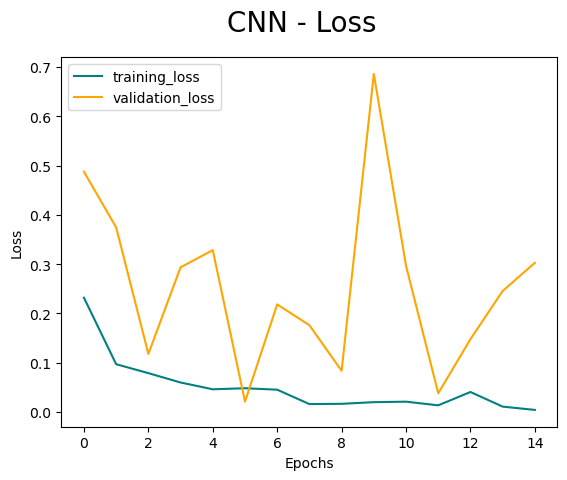

In [113]:
fig = plt.figure()
plt.plot(history_cnn.history['loss'], color='teal', label='training_loss')
plt.plot(history_cnn.history['val_loss'], color='orange', label='validation_loss')
fig.suptitle('CNN - Loss', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

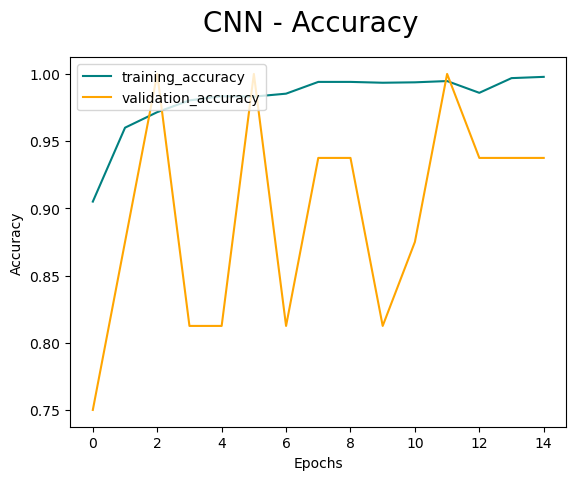

In [114]:
fig = plt.figure()
plt.plot(history_cnn.history['acc'], color='teal', label='training_accuracy')
plt.plot(history_cnn.history['val_acc'], color='orange', label='validation_accuracy')
fig.suptitle('CNN - Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [115]:
cm_cnn = confusion_matrix(
                np.concatenate([np.argmax(test_gen_cnn[i][1], axis=1) for i in range(len(test_gen_cnn))]),    
                np.argmax(model.predict_generator(test_gen_cnn, steps=len(test_gen_cnn)), axis=1) 
                         )

2022-11-27 16:22:53.864906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


##### Pre-trained model: vgg16

Reference: https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

In [ ]:
x_train_vgg16 = x_train_4dim.copy()
x_test_vgg16 = x_test_4dim.copy()

In [ ]:
y_train_vgg16 = np.asarray(y_train_2dim).astype('float32').reshape((-1,1))
y_test_vgg16 = np.asarray(y_test_2dim).astype('float32').reshape((-1,1))

In [ ]:
datagen.fit(x_train_vgg16)
train_gen_vgg16 = datagen.flow(x_train_vgg16, y_train_vgg16, batch_size=32)

In [ ]:
datagen.fit(x_test_vgg16)
test_gen_vgg16 = datagen.flow(x_test_vgg16, y_test_vgg16, batch_size=32)

In [ ]:
base_model = VGG16(input_shape = (224, 224, 1),
                   include_top = False,
                   weights = None)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])
model.summary()

In [ ]:
history_vgghist = model.fit(train_gen_vgg16, validation_data = test_gen_vgg16, steps_per_epoch = 100, epochs = 20)

In [ ]:
# Use model.save('path/model.h5') to save a keras model.
model.save('saved_model/vgg16_model.h5')

In [ ]:
# Load back our saved model.
vgg16_model = tf.keras.models.load_model('saved_model/vgg16_model.h5')

In [ ]:
vgg16_model.summary()

In [ ]:
# Get loss and accuracy on our test data.
vgg16_loss, vgg16_acc = vgg16_model.evaluate(x_test_vgg16, y_test_vgg16, verbose=2)
print('vgg16 model, accuracy: {:5.2f}%'.format(100 * vgg16_acc))

In [ ]:
# Save the notebook checkpoints.
saver = tf.train.Saver()
sess = keras.backend.get_sessions()
saver.save(sess, 'saved_model/session.ckpt')

In [ ]:
# The following restores the session while loading.
# First, load the saved model.
vgg16_model = tf.keras.models.load_model('saved_model/vgg16_model.h5')

# Redefine functions to call the session.
saver = tf.train.Saver()
sess = keras.backend.get_sessions()
saver.restore(sess, 'saved_model/vgg16_session.ckpt')

In [ ]:
fig = plt.figure()
plt.plot(history_vgghist.history['loss'], color='teal', label='training_loss')
plt.plot(history_vgghist.history['val_loss'], color='orange', label='validation_loss')
fig.suptitle('VGG16 - Loss', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(history_vgghist.history['acc'], color='teal', label='training_accuracy')
plt.plot(history_vgghist.history['val_acc'], color='orange', label='validation_accuracy')
fig.suptitle('VGG16 - Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# need revision - true labels only extracted "0" values (missing "1")
cm_vgg16 = confusion_matrix(
                np.concatenate([np.argmax(test_gen_vgg16[i][1], axis=1) for i in range(len(test_gen_vgg16))]),    
                np.argmax(model.predict_generator(test_gen_vgg16, steps=len(test_gen_vgg16)), axis=1) 
                         )

## Stage 4: Model performance and evaluation

### Confusion Matrix

##### SVM

In [116]:
disp_cm_svm_1 = ConfusionMatrixDisplay(confusion_matrix=cm_svm_1, display_labels=svm.classes_)
disp_cm_svm_1.plot()

NameError: name 'cm_svm_1' is not defined

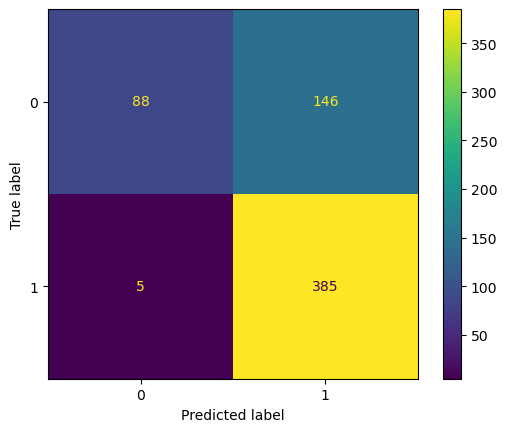

In [117]:
disp_cm_svm_2 = ConfusionMatrixDisplay(confusion_matrix=cm_svm_2, display_labels=svm.classes_)
disp_cm_svm_2.plot()

##### KNN

In [ ]:
#disp_cm_knn_1 = ConfusionMatrixDisplay(confusion_matrix=cm_knn_1, display_labels=knn.classes_)
#disp_cm_knn_1.plot()

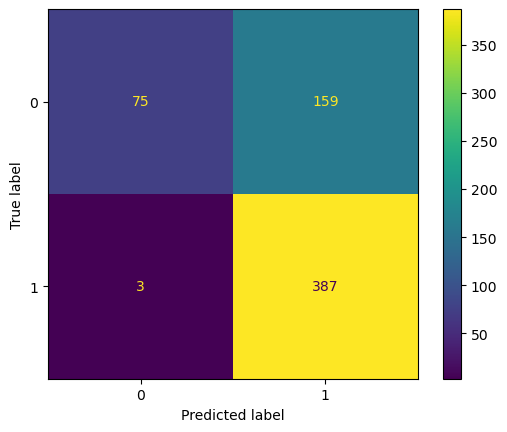

In [118]:
disp_cm_knn_2 = ConfusionMatrixDisplay(confusion_matrix=cm_knn_2, display_labels=knn.classes_)
disp_cm_knn_2.plot()

##### Decision Tree

In [ ]:
#disp_cm_dt_1 = ConfusionMatrixDisplay(confusion_matrix=cm_dt_1, display_labels=dt.classes_)
#disp_cm_dt_1.plot()

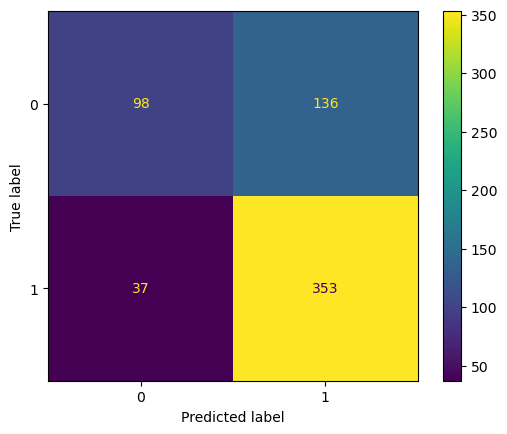

In [119]:
disp_cm_dt_2 = ConfusionMatrixDisplay(confusion_matrix=cm_dt_2, display_labels=dt.classes_)
disp_cm_dt_2.plot()

##### Random Forest

In [ ]:
#disp_cm_rf_1 = ConfusionMatrixDisplay(confusion_matrix=cm_rf_1, display_labels=rf.classes_)
#disp_cm_rf_1.plot()

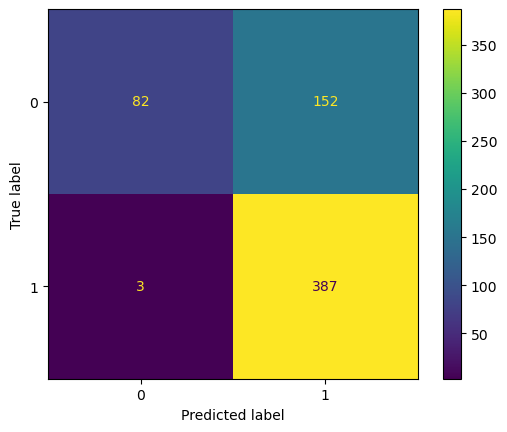

In [120]:
disp_cm_rf_2 = ConfusionMatrixDisplay(confusion_matrix=cm_rf_2, display_labels=rf.classes_)
disp_cm_rf_2.plot()

##### CNN

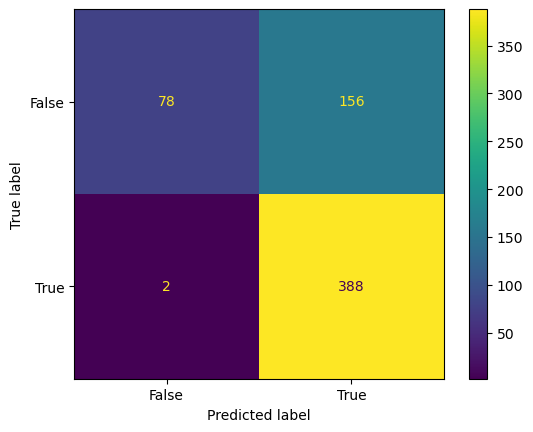

In [121]:
cm_cnn
disp_cm_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=[False, True])
disp_cm_cnn.plot()

##### vgg16

In [ ]:
cm_vgg16
disp_cm_vgg16 = ConfusionMatrixDisplay(confusion_matrix=cm_vgg16, display_labels=[False, True])
disp_cm_vgg16.plot()

### ROC Curve

In [122]:
plt.figure(0).clf()

# SVM
svm_pred = svm.predict_proba(feat_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, svm_pred)
auc = round(roc_auc_score(y_test, svm_pred), 4)
plt.plot(fpr,tpr,label="SVM, AUC="+str(auc))

# KNN
knn_pred = knn.predict_proba(feat_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, knn_pred)
auc = round(roc_auc_score(y_test, knn_pred), 4)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))

# DT
dt_pred = dt.predict_proba(feat_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, dt_pred)
auc = round(roc_auc_score(y_test, dt_pred), 4)
plt.plot(fpr,tpr,label="DT, AUC="+str(auc))

# RF
rf_pred = rf.predict_proba(feat_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, rf_pred)
auc = round(roc_auc_score(y_test, rf_pred), 4)
plt.plot(fpr,tpr,label="RF, AUC="+str(auc))

plt.legend()

AttributeError: predict_proba is not available when  probability=False

<Figure size 640x480 with 0 Axes>

### Performance Metrics

##### Accuracy

In [ ]:
svm_acc = accuracy_score(y_test, svm.predict(feat_test))
knn_acc = accuracy_score(y_test, knn.predict(feat_test))
dt_acc = accuracy_score(y_test, dt.predict(feat_test))
rf_acc = accuracy_score(y_test, rf.predict(feat_test))
cnn_acc = accuracy_score(y_test, CNN_model.predict(feat_test))

##### Recall

In [ ]:
svm_rec = recall_score(y_test, svm.predict(feat_test))
knn_rec = recall_score(y_test, knn.predict(feat_test))
dt_rec = recall_score(y_test, dt.predict(feat_test))
rf_rec = recall_score(y_test, rf.predict(feat_test))

##### Precision

In [ ]:
svm_prec = precision_score(y_test, svm.predict(feat_test))
knn_prec = precision_score(y_test, knn.predict(feat_test))
dt_prec = precision_score(y_test, dt.predict(feat_test))
rf_prec = precision_score(y_test, rf.predict(feat_test))

##### F1 Score

In [ ]:
svm_f1 = f1_score(y_test, svm.predict(feat_test))
knn_f1 = f1_score(y_test, knn.predict(feat_test))
dt_f1 = f1_score(y_test, dt.predict(feat_test))
rf_f1 = f1_score(y_test, rf.predict(feat_test))

##### AUC

In [ ]:
svm_auc = roc_auc_score(y_test, svm.predict(feat_test))
knn_auc = roc_auc_score(y_test, knn.predict(feat_test))
dt_auc = roc_auc_score(y_test, dt.predict(feat_test))
rf_auc = roc_auc_score(y_test, rf.predict(feat_test))

In [ ]:
scores = {'Model'    : ['SVM', 'KNN', 'Decision Tree', 'Random Forest'], 
          'Accuracy' : [svm_acc, knn_acc, dt_acc, rf_acc],
          'Recall'   : [svm_rec, knn_rec, dt_rec, rf_rec],
          'Precision': [svm_prec, knn_prec, dt_prec, rf_prec],
          'F1 Score' : [svm_f1, knn_f1, dt_f1, rf_f1],
          'AUC'      : [svm_auc, knn_auc, dt_auc, rf_auc]
         }

In [ ]:
pd.DataFrame(scores)

## Stage 5: Model Deployment